In [1]:
# for dataset manipulation
import pandas as pd
import numpy as np
import datetime
import json
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


# for model
import joblib
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from sklearn import linear_model

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict, ShuffleSplit
from sklearn.metrics import r2_score
from sklearn import metrics


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.model_selection import StratifiedKFold # cross-validation

# for model visualization
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt

In [2]:
data_path = ('/Users/chenhaoyi/JupyterNotebook/SummerProject/data/new_model_data.csv')
df = pd.read_csv(data_path)

feature_list = ['County', 'population_density', 'FPLi', 'logG', 'Logperin',
                'population', 'pergdp', 'C_Age_0_4', 'C_Age_5_14', 'C_Age_15_24',
                'C_Age_25_34', 'C_Age_35_44', 'C_Age_45_54', 'C_Age_55_64',
                'C_Age_65_74', 'C_Age_75_84', 'C_Age_85plus', 'T_total',
                'Clinician_Count_DO', 'Nurse_practitioner_Count', 'Bed Census',
                'Total Staffed Bed Capacity',
                'Percent Remaining Vent Capacity', 'Ventilator Capacity', 'C_65_plus',
                'C_65_plus_rate', 'Lethality','Deaths']


df = df.loc[:,feature_list]



data_population = ('/Users/chenhaoyi/JupyterNotebook/SummerProject/Florida_county_population.csv')
df_pop = pd.read_csv(data_population)

l1 = df_pop['population']
l2 = df['T_total']
ca = (l2/l1)*100
df['test_per_pop'] = ca

df_data = df.drop(['County', 'Lethality','Deaths'], axis=1)
df_target = df.Deaths

In [3]:
lethality_train, lethality_test = train_test_split(df, test_size=0.2,
                                                   random_state=18)


X_train = lethality_train.drop(['County', 'Lethality', 'Deaths'], axis=1)
y_train = lethality_train.Deaths

X_test = lethality_test.drop(['County', 'Lethality','Deaths'], axis=1)
y_test = lethality_test.Deaths

X_train = X_train.copy().reset_index(drop=True)
y_train = y_train.copy().reset_index(drop=True)

X_test = X_test.copy().reset_index(drop=True)
y_test = y_test.copy().reset_index(drop=True)

In [4]:
randomforest_regmodel_deaths = RandomForestRegressor(max_features = None, min_samples_split = 5, 
                                                     min_samples_leaf = 2,
                                                     max_depth = 6, n_estimators = 100, criterion='mse',
                                                     oob_score = True, random_state = 18)

randomforest_regmodel_deaths.fit(X_train, y_train)
print(randomforest_regmodel_deaths.score(X_test, y_test))

0.7948996405298778


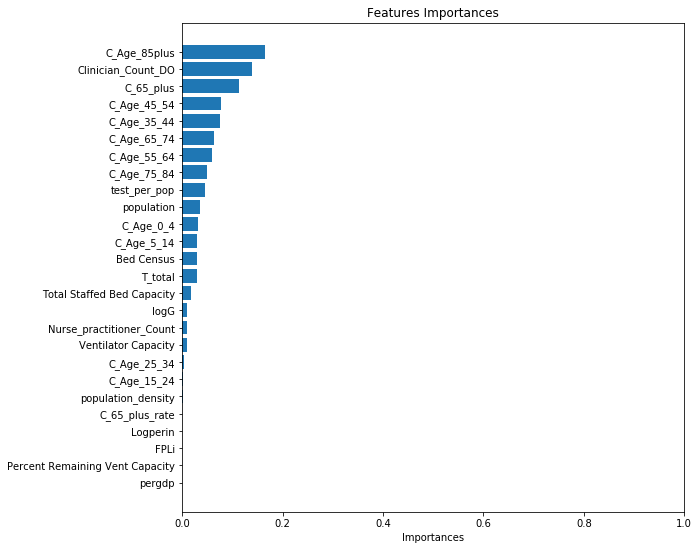

In [5]:
feature_importance = pd.Series(randomforest_regmodel_deaths.feature_importances_, index=X_train.columns).sort_values(ascending= True)

y_importances = feature_importance
x_importances = feature_importance.index
y_pos = np.arange(len(x_importances))


fig, ax = plt.subplots(figsize=(9, 9))
plt.barh(y_pos, y_importances, align='center')
plt.yticks(y_pos, x_importances)
plt.xlabel('Importances')
plt.xlim(0,1)
plt.title('Features Importances')
plt.show()

0.7955976237829099


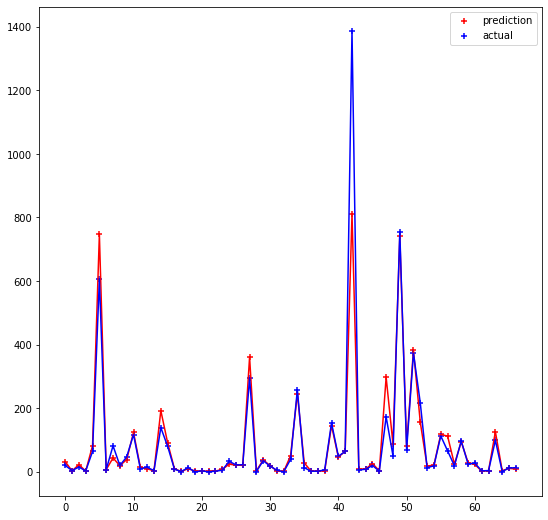

In [6]:
y_prediction = randomforest_regmodel_deaths.predict(df_data)
print(r2_score(y_prediction, df_target))


fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(range(len(y_prediction)), y_prediction, c='red', alpha=1, marker='+',label = 'prediction')
plt.plot(range(len(y_prediction)), y_prediction, c = 'red')
plt.scatter(range(len(df_target)), df_target, c='blue', alpha=1, marker='+', label = 'actual') 
plt.plot(range(len(df_target)), df_target, c = 'blue')
plt.legend()
plt.show()

y = 19.06464963647977 + 0.7642279566487297 * x
0.8793788048028919
0.8642450143946179


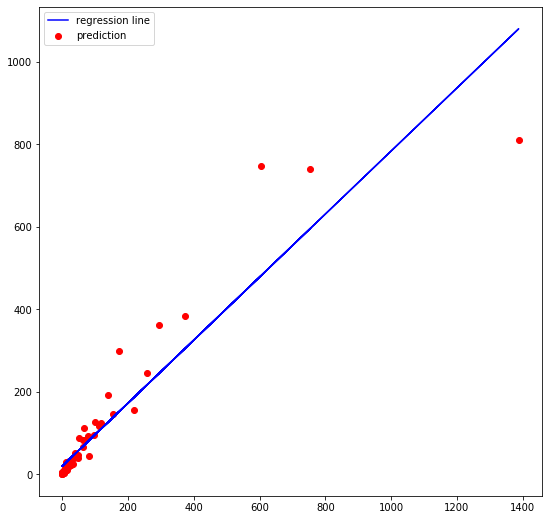

In [7]:
y_prediction = randomforest_regmodel_deaths.predict(df_data)
actual = df_target

df_plot = pd.DataFrame({'County':df.County,'predictions':y_prediction,'actual':actual})
#df_plot.to_excel('/Users/chenhaoyi/JupyterNotebook/SummerProject/data/data.xlsx')


plot_actual = df_target.values.reshape(-1, 1)
plot_prediction = y_prediction.reshape(-1, 1)
plot_model = LinearRegression()
plot_model.fit(plot_actual, plot_prediction)


a = plot_model.intercept_
b = plot_model.coef_
a = float(a)
b = float(b)
print('y = {} + {} * x'.format(a, b))
print(plot_model.score(plot_actual, plot_prediction))
Y_plot_pred = plot_model.predict(plot_actual)
print(r2_score(actual,y_prediction))


fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(actual, y_prediction, c = 'r', marker = 'o', label = 'prediction')
plt.plot(df_target, Y_plot_pred, c = 'b' , label = 'regression line')

plt.legend()
plt.show()

# get tree model graphic

Estimators = randomforest_regmodel_deaths.estimators_
for index, model in enumerate(Estimators):
    filename = '/Users/chenhaoyi/JupyterNotebook/SummerProject/Graphic/death_test/random_forest_' + str(index) + '.pdf'
    dot_data = tree.export_graphviz(model , out_file=None,
                         feature_names=X_train.columns,
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    graph.write_pdf(filename)

# Calculate r2

In [8]:
#For train dataset
yhat = randomforest_regmodel_deaths.predict(X_train)
ss_total = np.sum(np.square(y_train - np.mean(y_train)))
ss_residual = np.sum(np.square(y_train - yhat))
ss_regression = np.sum(np.square(yhat - np.mean(y_train)))


r2_calculation = 1 - (ss_residual / ss_total) 



print("SS_Total: ",ss_total)
print("SS_Residual(Sum square error): ", ss_residual)
print("SS_regression: ",ss_regression)
print(r2_calculation)
print(r2_score(y_train, yhat))

SS_Total:  2771428.1886792453
SS_Residual(Sum square error):  378108.071056381
SS_regression:  1828180.9791030104
0.8635692338697859
0.8635692338697859


In [9]:
#For test dataset
yhat = randomforest_regmodel_deaths.predict(X_test)
ss_total = np.sum(np.square(y_test - np.mean(y_test)))
ss_residual = np.sum(np.square(y_test - yhat))
ss_regression = np.sum(np.square(yhat - np.mean(y_test)))

r2_calculation = 1 - (ss_residual / ss_total) 



print("SS_Total: ",ss_total)
print("SS_Residual(Sum square error): ", ss_residual)
print("SS_regression: ",ss_regression)
print(r2_calculation)
print(r2_score(y_test, yhat))

SS_Total:  47728.92857142857
SS_Residual(Sum square error):  9789.220407123783
SS_regression:  37799.535932519604
0.7948996405298778
0.7948996405298778


In [10]:
#For whole dataset
yhat = randomforest_regmodel_deaths.predict(df_data)
ss_total = np.sum(np.square(df_target - np.mean(df_target)))
ss_residual = np.sum(np.square(df_target - yhat))
ss_regression = np.sum(np.square(yhat - np.mean(df_target)))

r2_calculation = 1 - (ss_residual / ss_total) 

print("SS_Total: ",ss_total)
print("SS_Residual(Sum square error): ", ss_residual)
print("SS_regression: ",ss_regression)
print(r2_calculation)
print(r2_score(df_target, yhat))

SS_Total:  2857333.671641791
SS_Residual(Sum square error):  387897.2914635048
SS_regression:  1897872.1665065512
0.8642450143946179
0.8642450143946179


# For mse and rmse

In [11]:
#Calculate rmse for train
yhat_train = randomforest_regmodel_deaths.predict(X_train)
mse_train = np.sum(np.square(y_train - yhat_train)) / len(X_train)
rmse_train = np.sqrt(mse_train)

print('mse_train: ',mse_train)
print('rmse_train: ',rmse_train)

#Calculate rmse for test
yhat_test = randomforest_regmodel_deaths.predict(X_test)
mse_test = np.sum(np.square(y_test - yhat_test)) / len(X_test)
rmse_test = np.sqrt(mse_test)

print('mse_test: ',mse_test)
print('rmse_test: ',rmse_test)


#Calculate rmse for whole dataset
yhat = randomforest_regmodel_deaths.predict(df_data)
mse = np.sum(np.square(df_target - yhat)) / len(df_data)
rmse = np.sqrt(mse)

print('mse: ',mse)
print('rmse: ',rmse)

mse_train:  7134.114548233603
rmse_train:  84.46368774943232
mse_test:  699.2300290802702
rmse_test:  26.4429580244017
mse:  5789.511812888131
rmse:  76.08884157935466
